In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from toolz import partial, valmap
from tqdm.auto import tqdm
from aging.plotting import figure, format_plots, add_identity, legend
from aging.behavior.bio_age_model import (
    age_normalizer_factory,
    neg_log_likelihood,
    create_splines,
    optimize,
    get_biological_age,
    masked_xval,
    stratified_xval,
    fit_model
)
from itertools import product
from sklearn.preprocessing import OneHotEncoder
from toolz import pluck

In [2]:
warnings.simplefilter("ignore")
format_plots()

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()

In [4]:
df = pd.read_parquet(
    # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_v2_males_relabeled_counts_matrix_v00.parquet"
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)
mask = df.index.get_level_values("age") < 100
df = df[mask].copy()

n_syllables = 55
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

size_df = pd.read_parquet(
    # '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_v2_males_mouse_area_df_v00.parquet'
    '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_mouse_area_df_v00.parquet'
)

# sizes_col = size_df.groupby('age')['quant_0.5'].transform(demean)
# sizes_col = size_df.groupby('age')['quant_0.5'].transform(zscore)
sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.loc[df.index]

sizes_col.loc[sizes_col == 0] = np.nan
sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

sizes_col = sizes_col.loc[df.index]

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
mouse_ids = label_encoder.fit_transform(
    sizes_col.index.get_level_values("mouse").to_numpy()[:, None]
).T

In [16]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy(),  # models > 1
    "mice": mouse_ids,  # models > 2
}

hypparams = {
    "min_age": 1,
    "max_age": age.max() + 5,
    "age_sd": 10,  # weeks
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
    "n_age_samples": 500,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_development_splines": 9,
    "n_syllables": n_syllables,
    "n_keep_sylls": 30,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "lr": 0.2,
    "n_opt_iter": 500,
}

In [17]:
# hypparams['n_development_splines'] = 7
# output_v5 = masked_xval(features, hypparams, model_version=5, n_repeats=4)
# output_v3 = masked_xval(features, hypparams, model_version=3, n_repeats=4)
output_v2 = masked_xval(features, hypparams, model_version=2, n_repeats=3)

Text(0, 0.5, 'bio age')

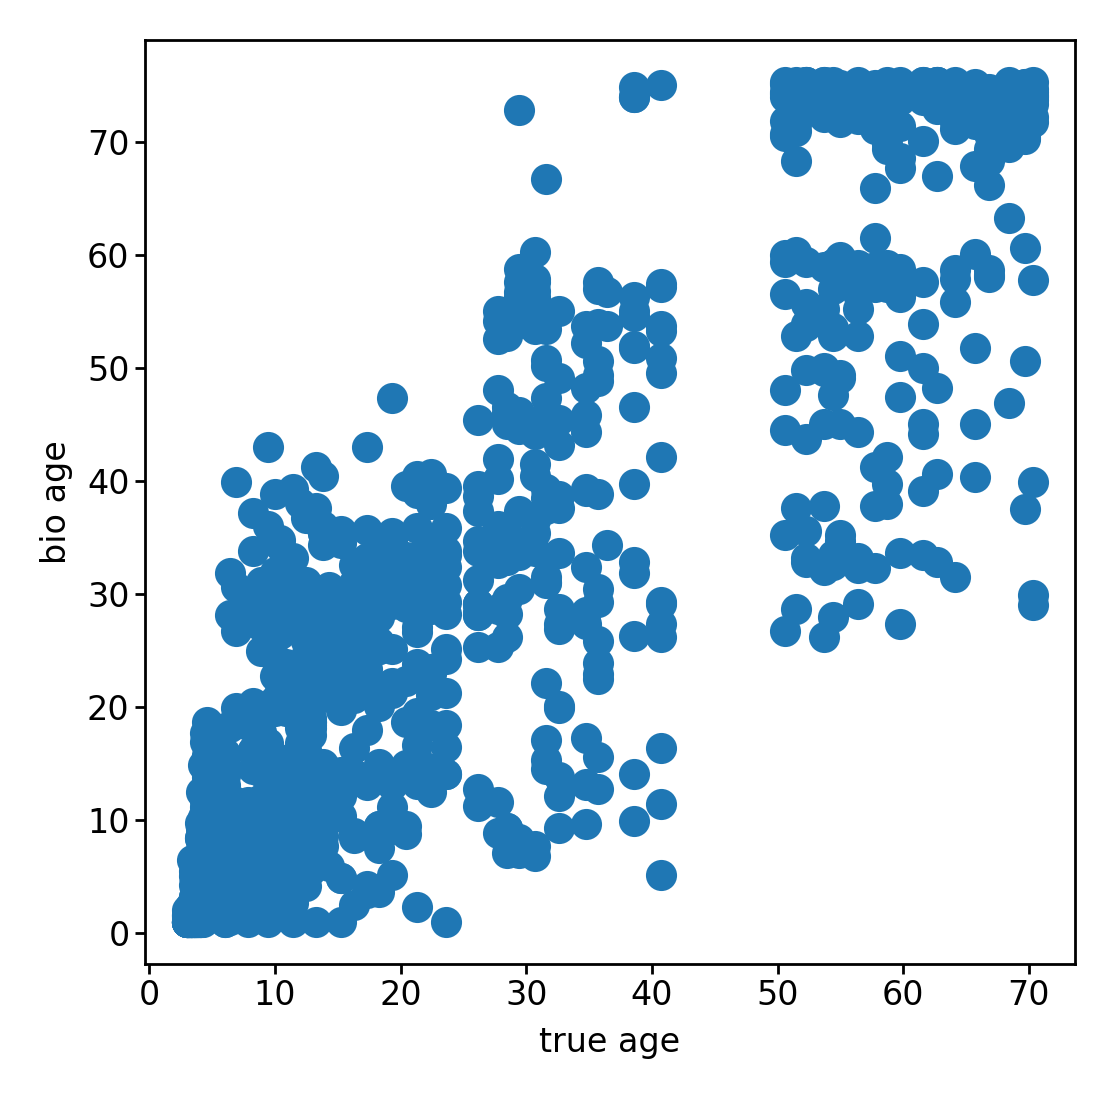

In [18]:
v = output_v2[0]
plt.figure()
plt.scatter(v['true_ages'], v['bio_ages'])
plt.xlabel("true age")
plt.ylabel("bio age")

In [11]:
list(v['params'])

['bio_basis_weights', 'size_basis_weights']

In [12]:
v['params']['size_basis_weights'].shape

(55, 5)

In [13]:
indiv = df.index.get_level_values('mouse')

In [14]:
age_df = pd.DataFrame({'bio': v['bio_ages'], 'chron': v['true_ages']}, index=indiv)

<Axes: xlabel='chron'>

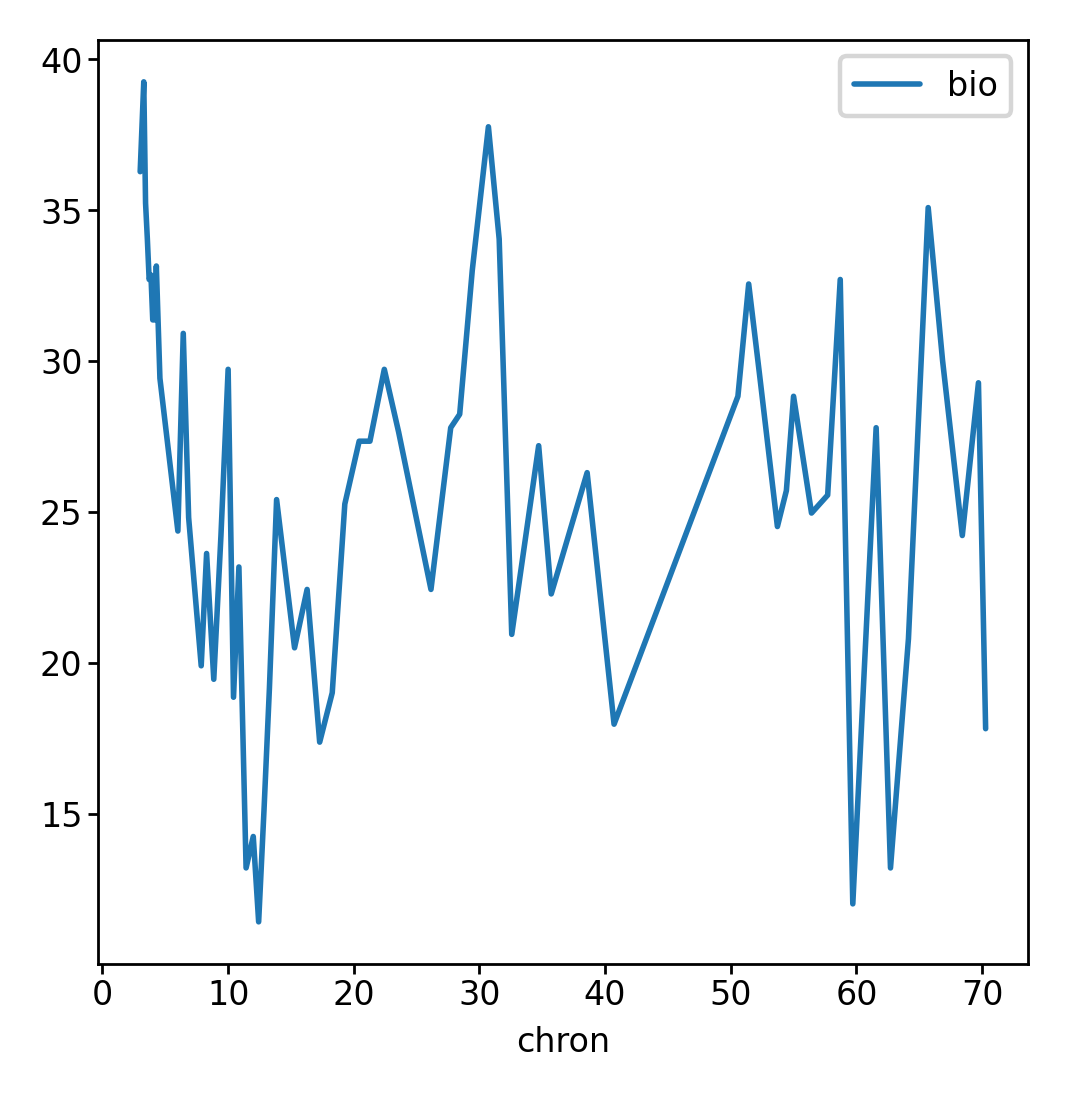

In [15]:
age_df.loc['01_01'].plot(x='chron', y='bio')

In [47]:
lls = {}
r2s = {}
for model in tqdm(range(0, 6)):
    if model == 0:
        hypparams['bio_params_sd'] = 10
    else:
        hypparams['bio_params_sd'] = 0.3
    output = masked_xval(features, hypparams, model_version=model, n_repeats=4)
    lls[model] = list(pluck('heldout_ll', output.values()))
    r2s[model] = list(pluck('heldout_r2_total', output.values()))
    print(lls[model])
    print(r2s[model])
ll_df = pd.DataFrame(lls)
r2_df = pd.DataFrame(r2s)

  0%|          | 0/6 [00:00<?, ?it/s]

[-1153894, -1154707, -1153554, -1154044]
[0.332965370557418, 0.3322527079913212, 0.3366796135528267, 0.32712515723727814]
[-1124055, -1124253, -1123874, -1124087]
[0.4989624773892401, 0.49399191427883354, 0.5075033317160212, 0.4993762140137233]
[-1122821, -1122713, -1122163, -1122353]
[0.542352125200906, 0.5396347681088428, 0.555473980256527, 0.5530876060078818]
[-1121349, -1122532, -1121141, -1121975]
[0.5798243157762146, 0.5463199304733428, 0.5801366364103867, 0.5657372127441792]
[-1121241, -1120806, -1121367, -1121142]
[0.5643331471549523, 0.5695906200121128, 0.5387402471147832, 0.5553978931423085]
[-1120165, -1119931, -1120225, -1119788]
[0.5938079197790018, 0.5990007206420105, 0.582234268653564, 0.5941122951592654]


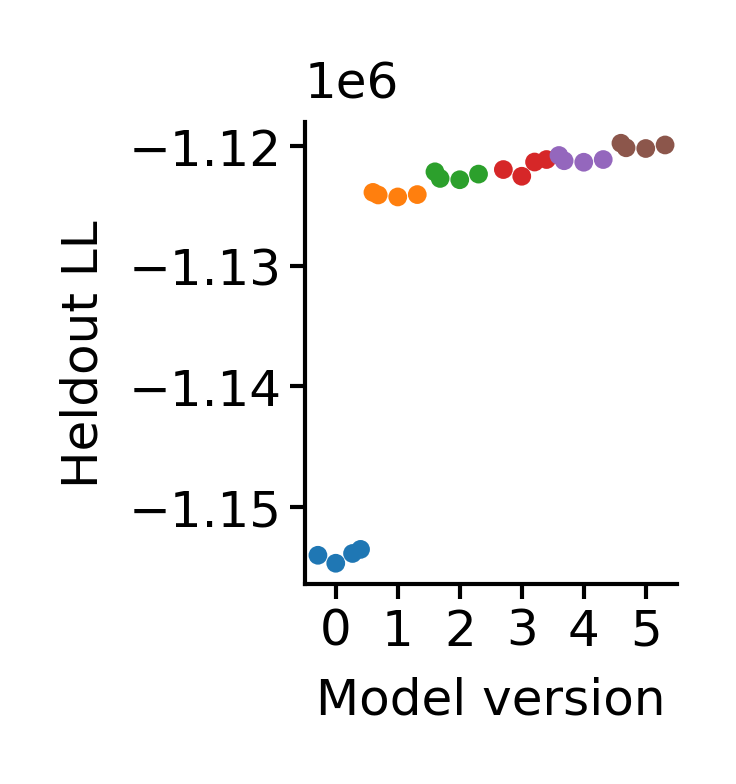

In [48]:
fig = figure(0.8, 1)
ax = sns.swarmplot(data=ll_df, size=2.25)
ax.set(xlabel="Model version", ylabel="Heldout LL")
sns.despine()

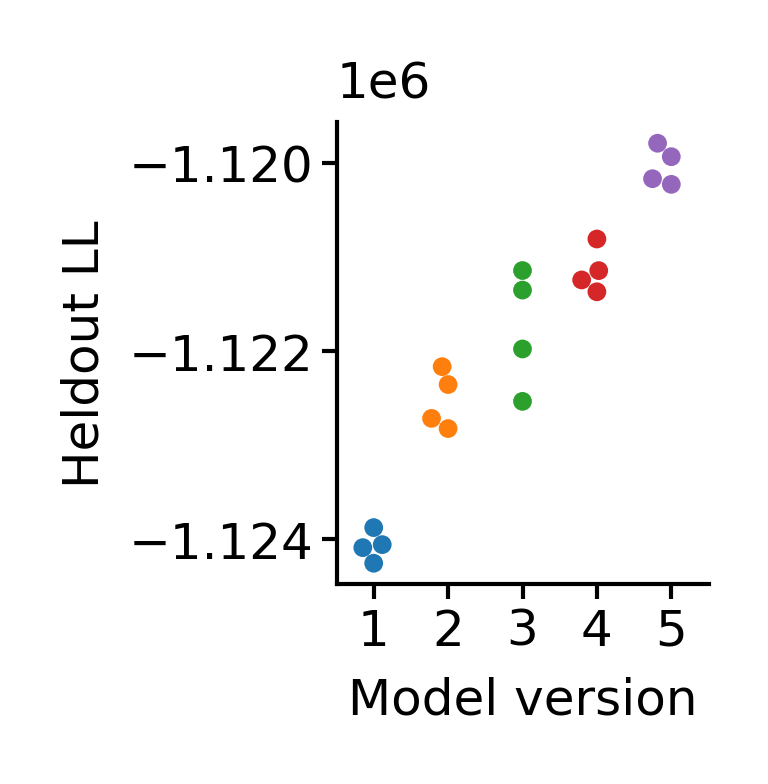

In [49]:
fig = figure(0.8, 1)
ax = sns.swarmplot(data=ll_df.iloc[:, 1:], size=2.25)
ax.set(xlabel="Model version", ylabel="Heldout LL")
sns.despine()

In [28]:
fig = figure(1.7, 1)

for k in output:
    p = output[k]["params"]
    bias_scale = (jnp.exp(p["development_weights"]) @ output[k]['init_components'].bases['development']).flatten()
    plt.plot(
        np.linspace(hypparams["min_age"], hypparams["max_age"], hypparams["n_age_samples"]),
        bias_scale
    )

# plt.ylim(0, None)
# plt.xlim(0, None)
plt.xlabel("Bio age (weeks)")
plt.ylabel("Individuality influence")
sns.despine()

KeyError: 'development'

<Figure size 510x300 with 0 Axes>